In [36]:
# install.packages("partykit")
# install.packages("pre")
library("partykit")
source("SimData.r")
library("party")
library(MASS)
library("glmertree")
library("caret") # importance and rfe
source("SimData.r")
library("randomForest")
library("rpart")
library("fuzzyforest")
library("WGCNA")
library("pre")

# Data

In [37]:
# Important Note
# If you want to normalize the PC, please normalize for both train and test set
# Dangerous: the PC can be +PC or -PC so for test set, you may want to flip the sign
# of the PC to see if it has a better result(which should be correct), since
# the coefficient of the linear model is fixed after training

# Normalizing or not, all the parameters of the resulting tree are the same
# except that the coefficients for PC are different

In [42]:
# training data
set.seed(100)

# No time structure
n = 500 # num of observations
p = 400
p0 = 100

cor_feature = 0.8

#### covariance matrix between features: it is either 0 (independent) or cor_feature ####
cov_feature = matrix(0,nrow = p, ncol = p)
# cov within the first three modules
cov_star = matrix(cor_feature,nrow = p0,ncol = p0)
diag(cov_star)=1
# put cov_star into cov_feature
cov_feature[1:p0,1:p0] = cov_star
cov_feature[(p0+1):(2*p0),(p0+1):(2*p0)] = cov_star
cov_feature[(2*p0+1):(3*p0),(2*p0+1):(3*p0)] = cov_star
cov_feature[(3*p0+1):(4*p0),(3*p0+1):(4*p0)] = diag(p0)
####

X = mvrnorm(n = n, rep(0, p), cov_feature)
y = f_sim(X)
data = cbind(X,y)
data = data.frame(data)

#add PC
data$PC1 = (prcomp(X[,1:100], scale = TRUE)$x)[,1]
# data$PC1 = scale(data$PC1)/norm(scale(data$PC1),type="2")
data$PC2 = (prcomp(X[,101:200], scale = TRUE)$x)[,1]
data$PC3 = (prcomp(X[,201:300], scale = TRUE)$x)[,1] 

# PC of true features
data$PCone = (prcomp(X[,1:3], scale = TRUE)$x)[,1]

data[1:5,]

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V396,V397,V398,V399,V400,y,PC1,PC2,PC3,PCone
-0.9193970,0.4416402,-1.6874364,-1.2282920,-1.4719190,-0.7258681,-1.0007080,-0.5809589,-0.6480068,-1.0717893,...,1.0363352,-0.0749961081,0.7390165,1.3488629,-1.1525995,-12.2783192,-9.982050,-13.036248,-4.1435250,-1.245483
-0.8763958,-0.9931904,-0.5903482,-0.8938970,-1.2517455,-0.4072832,-1.8738281,-1.2849527,-1.0130168,-0.3346373,...,-0.1901736,-0.9470827924,-2.1501213,-0.2297432,0.4641607,-9.5949749,-10.748425,2.111788,1.5080274,-1.430273
-0.6046310,-0.3771163,-0.8634822,-0.9587687,-0.8106843,0.2184991,-1.4998981,-0.8083261,-0.2937366,-0.7714238,...,1.2566406,0.0003758095,0.8217849,-1.7324848,0.7289325,7.1053112,-5.392401,-3.561392,-0.3662763,-1.067022
0.1238469,-1.4196072,-0.6497125,-0.6689533,-1.2245386,-1.3911706,-0.3050343,-0.9567550,-1.2421426,-0.8961609,...,0.8235160,-1.5249574007,1.6537538,-0.6273090,0.4106175,0.8905166,-9.805820,-17.196481,8.2508071,-1.128345
-1.5415618,-0.9090509,-0.5699499,-1.4404816,-0.9707221,-1.2020829,-1.1336156,-0.1288167,-1.5646634,-0.2275436,...,-1.1591249,0.0983516474,-0.5823098,-0.2405078,-1.4611472,-14.3837753,-10.347417,1.481799,1.3901661,-1.758941


In [43]:
# test data set
set.seed(101)

# No time structure
n_test = 100 # num of observations

X_test = mvrnorm(n = n_test, rep(0, p), cov_feature)
y_test = f_sim(X_test)
data_test = cbind(X_test,y_test)
data_test = data.frame(data_test)

# pca
# DANGEROUS: the PC can be +PC or -PC, so the prediction on test data shoule
# better not use PC of data_test! (the coefficient of linear model is fixed)
data_test$PC1 = -(prcomp(X_test[,1:100], scale = TRUE)$x)[,1]
# data_test$PC1 = scale(data_test$PC1)/norm(scale(data_test$PC1),type="2")
data_test$PC2 = (prcomp(X_test[,101:200], scale = TRUE)$x)[,1]
data_test$PC3 = (prcomp(X_test[,201:300], scale = TRUE)$x)[,1] 

data_test$PCone = -(prcomp(X_test[,1:3], scale = TRUE)$x)[,1]

data_test[1:5,]

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V396,V397,V398,V399,V400,y_test,PC1,PC2,PC3,PCone
0.4270146,-1.0986628,0.9695128,0.05067257,0.2933707,-0.158750199,-0.6469059,-0.1925699,0.001994361,0.2925696,...,0.02777378,-0.3893127,-1.27235813,-0.3205369,-1.1658569,2.8703057,1.646139,-2.774867,2.782679,0.2060893
1.4783423,1.5687687,0.3395318,1.41773161,1.5570561,0.985733254,1.9380964,0.7101339,2.118158414,1.0872465,...,0.14470549,-1.0726485,-0.66307158,-2.0919208,-0.2397987,16.2539751,13.862651,4.914693,-5.595904,2.2340094
-0.8272478,-0.7645924,0.1623561,-0.58407534,-1.2062563,-0.001602162,-0.2098308,-0.7230311,-0.264988245,-0.6045068,...,-0.23756438,-0.3953464,-0.29654313,-1.8518319,1.1843827,2.9703748,-4.199184,-19.428139,6.042681,-0.9084927
0.5505366,0.9756962,1.0634336,0.54076689,1.0100161,0.319491349,0.3742614,1.1606476,0.690067389,1.2396059,...,-0.74284806,-0.8449876,-0.57396643,0.4396653,0.2075084,9.2597353,7.934748,-10.878957,-2.348258,1.6872587
-0.9471237,-1.0009572,-1.2908256,-0.90432577,-0.5902960,-1.058124260,-0.9884839,-1.2096527,-1.228834809,-0.4429552,...,0.26090560,-0.6559405,-0.02617408,0.1419048,-0.0436326,-0.8451365,-12.037156,-7.026668,-3.335877,-2.0436544


In [40]:
# Methods for extracting names of splitting features used in a tree
# tree: a tree object; data: the train or test set
get_split_names = function(tree,data){
    # path: the string that contains all the node information
    paths <- pre:::list.rules(tree, removecomplements = FALSE)
    vnames = names(data)
    # the regex for a variable
    # tomatch = paste(paste(var,"<="),"|",paste(var,">"),sep="")
    # match to tomatch in path
    tmp = vnames[sapply(sapply(vnames, FUN = function(var) grep(paste(paste(var,"<="),"|",paste(var,">"),sep=""), paths)), length) > 0]
    return (tmp)
}

# Fuzzy model tree

In [59]:
# regress_var = paste("PC",c(1),sep="")
# regress_var = paste("V",8,sep="")
regress_var = paste("V",c(1,2,3),sep="")
# regress_var = paste("V",c(2,3,52,301,302,303),sep="")
# regress_var = "1"
# regress_var = "PCone"

# split_var = paste("V",1:100,sep="") # For demo: CHANGE 101 TO 100 and alpha=0.5
split_var = paste("V",301:400,sep="")
# split_var = paste("V",c(1,2,3,301,302,303),sep="")

Formula = as.formula(paste("y~",paste(regress_var,collapse = "+"), "|",
                         paste(split_var,collapse = "+")))

# If just use regular tree (not model tree,no regress_var): miss 302 and 303!
# split_var = paste("V",1:100,sep="")
# Formula = as.formula(paste("y~",paste(split_var,collapse="+")))

# Formula

In [60]:
# Note: the parameters of lmtree in "..." will 
# directly go into mob_control like alpha and maxdepth, minsize
system.time({
# the smaller the alpha, the deeper the tree. alpha =0.05 by default
# mytree = lmtree(Formula,data = data,minsize = 10,alpha = 0.2,maxdepth=5) # demo
mytree = lmtree(Formula,data = data,minsize = 10,alpha=0.2,maxdepth=4)
})

# mse on test set
mean((predict(mytree,newdata=data_test)-data_test$y_test)**2)

# the selected features
get_split_names(mytree,data)

# coef at the nodes
# coef(mytree)

# plot(mytree)

   user  system elapsed 
   0.47    0.00    0.48 

[1] 70.53569

[1] "V301" "V327"

In [19]:
# predict(mytree,newdata=data_test)
# coef(mytree)
mytree

Linear model tree

Model formula:
y ~ V1 + V2 + V3 + V301 + V302 + V303 | V1 + V2 + V3 + V301 + 
    V302 + V303

Fitted party:
[1] root
|   [2] V3 <= -0.26052
|   |   [3] V302 <= -0.63358: n = 62
|   |       (Intercept)          V1          V2          V3        V301        V302 
|   |        -5.3992220   4.9061094  -2.6414204  -3.8398221   4.4730769   0.9214048 
|   |              V303 
|   |        -4.0359157 
|   |   [4] V302 > -0.63358
|   |   |   [5] V2 <= -1.85011: n = 13
|   |   |       (Intercept)          V1          V2          V3        V301        V302 
|   |   |       -19.2213282   6.8758645  -7.1448288 -10.6240992   3.9638462  -0.9557021 
|   |   |              V303 
|   |   |         3.3388241 
|   |   |   [6] V2 > -1.85011: n = 130
|   |   |       (Intercept)          V1          V2          V3        V301        V302 
|   |   |        -1.7685655   4.8437031  -2.9337331  -0.7137225   5.0490944   1.2380242 
|   |   |              V303 
|   |   |         3.9459904 
|   [

# Other models for comparison

In [10]:
# the following tree method use one of formulae below

# use all covariates 
var = paste("V",1:400,sep="")

# only use important ones, which means cheating
# var = paste("V",c(1,2,3,301,302,303),sep="")

# use part of important ones
# var = paste("V",c(2,301,303),sep="") # part of important regress

# perturbation: mixture of correct and incorrect
# var = paste("V",c(1,301,99,100,307,299),sep="")

Formula = as.formula(paste("y~",paste(var,collapse = "+")))

   user  system elapsed 
   0.61    0.08    0.88 

[1] 73.46527

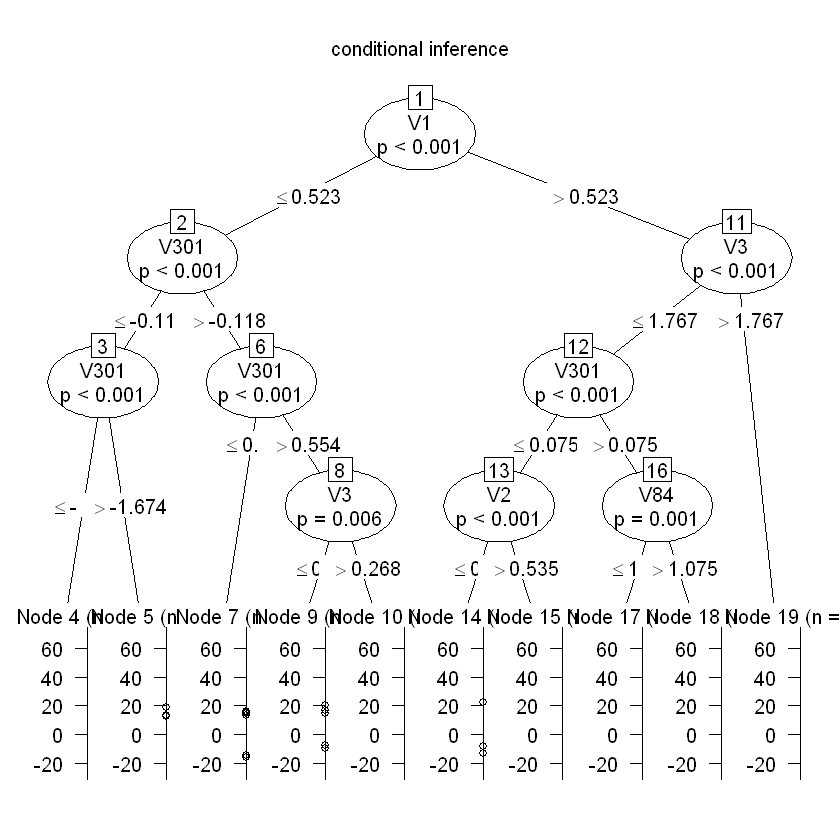

In [11]:
# ctree:  conditional inference framework.
system.time({c_tree <- ctree(
  Formula, 
  data = data)
})


# To see the importance of features in c_tree, run this instead
# system.time({c_tree <- train(
#   Formula, 
#   data = data,method="ctree")
# })
# varImp(c_tree)

plot(c_tree,main = "conditional inference")

# mean square error
mean((predict(c_tree,newdata=data_test)-data_test$y_test)**2)


In [64]:
# To see the importance of features in c_tree, run this instead
# system.time({c_tree <- train(
#   Formula, 
#   data = data,method="ctree")
# })
# varImp(c_tree)

   user  system elapsed 
  54.55    4.83   63.86 

loess r-squared variable importance

  only 20 most important variables shown (out of 400)

    Overall
V3   100.00
V2    99.75
V1    94.43
V23   87.70
V10   87.14
V43   86.12
V92   84.73
V52   84.71
V87   84.71
V32   84.28
V33   84.23
V84   84.11
V90   84.09
V51   83.95
V99   83.60
V93   83.20
V7    82.92
V65   82.66
V61   82.62
V42   82.60

For Fuzzy Forest
* The features I feed it cannot be too small (cannot be 6), or FF will raise an error
* When I use all the correct features and some other features (but not 1:400),
sometimes it is worse than 1:400 case, which is strange.

     mergeCloseModules: less than two proper modules.
      ..color levels are 0, 1
      ..there is nothing to merge.


Warning message in ff.default(X, y, Z, module_membership, screen_control, select_control, :
"ncol(X)*keep_fraction < number_selected
number_selected will be set to floor(ncol(X)*keep_fraction)"

   user  system elapsed 
  28.94    0.65   37.79 

[1] 72.36256

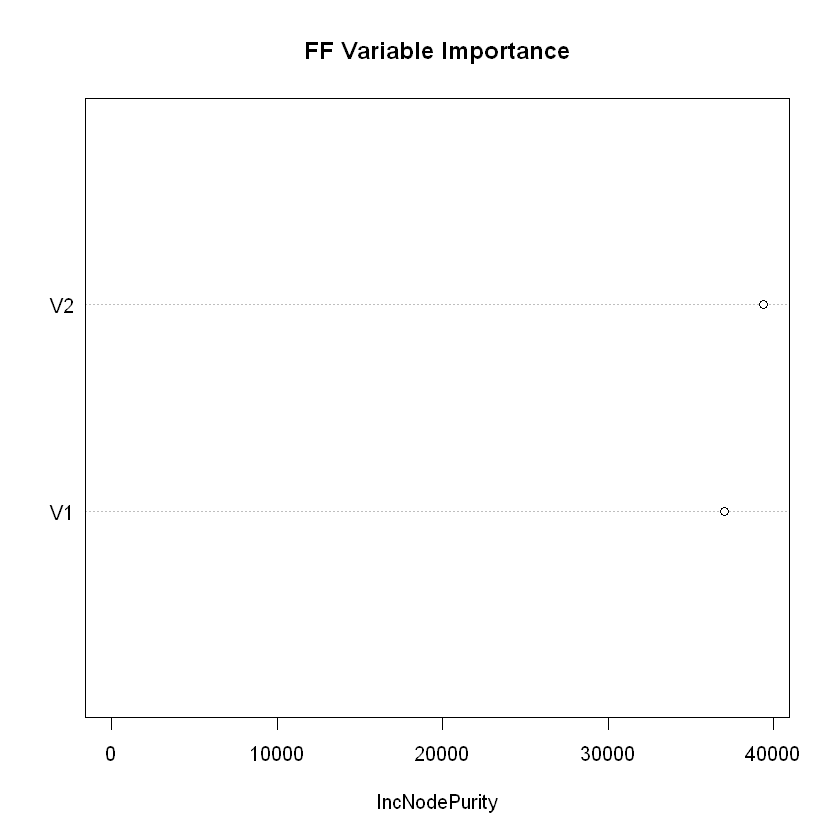

In [25]:
# Fuzzy Forest
# fuzzy forest
# Fuzzy Forest
# params is stored in xxx_control object
# power: belta (I choose it without much care)
WGCNA_params = WGCNA_control(power=3,TOMType="unsigned",minModuleSize=30,
                            numericLabels=TRUE,pamRespectsDendro=FALSE)

mtry_factor     = 1 # mtry = sqrt(p)*mtry_factor; mtry is the num in subspace method
drop_fraction   = 0.25 # drop xxx in each iteration of RFE-RF
number_selected = 8 # we want 10 out of all features
keep_fraction   = 0.05 # keep xxx for each module
min_ntree        = 500 # used for calculating ntree
ntree_factor    = 5 # used for calculating ntree
final_ntree     = 500 # RF in selecting step

screen_params = screen_control(drop_fraction = drop_fraction,
                              keep_fraction  = keep_fraction,
                              min_ntree      = min_ntree,
                              mtry_factor    = mtry_factor,
                              ntree_factor   = ntree_factor)

select_params = select_control(drop_fraction  = drop_fraction,
                              number_selected = number_selected,
                              min_ntree       = min_ntree,
                              mtry_factor     = mtry_factor,
                              ntree_factor    = ntree_factor)    

# var = paste("V",c(1:50,301,302,303),sep="")
# var = paste("V",1:400,sep="")
Formula = as.formula(paste("y~",paste(var,collapse = "+")))

# a "fuzzy_forest" object
system.time({
set.seed(20)
wff_fit = wff(Formula,data = data,WGCNA_params = WGCNA_params,
             screen_params = screen_params,
             select_params = select_params,
             final_ntree = final_ntree)
})

mean((predict(wff_fit,new_data=data_test[,1:400])-data_test$y_test)**2)
varImpPlot(wff_fit$final_rf,type=2,main="FF Variable Importance")

   user  system elapsed 
  25.85    0.43   33.34 

[1] 44.25691

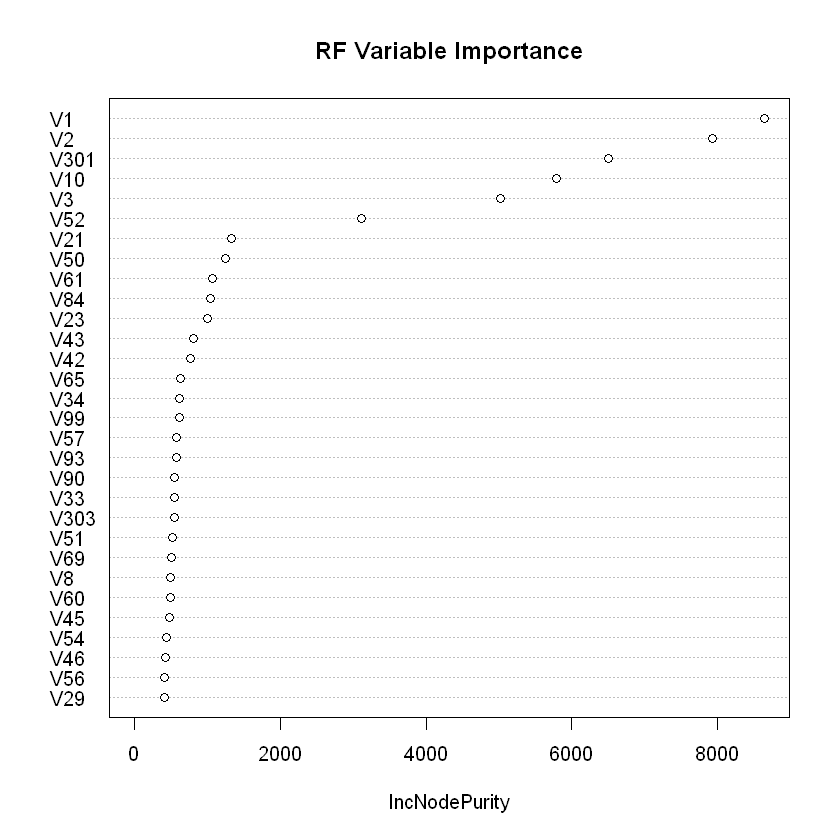

In [13]:
# Random Forest
system.time({
    set.seed(20)
    rf <- randomForest(data[,1:400],data$y)
})
mean((predict(rf,newdata=data_test[,1:400])-data_test$y_test)**2)
varImpPlot(rf,type=2,main="RF Variable Importance")

# Test PCA

In [119]:
DF<-data.frame(Maths=c(80, 90, 95), Science=c(85, 85, 80), 
               English=c(60, 70, 40), Music=c(55, 45, 50))
# DF = scale(DF)
DF

Maths,Science,English,Music
80,85,60,55
90,85,70,45
95,80,40,50


In [122]:
prcomp(DF, scale = TRUE)

Standard deviations (1, .., p=3):
[1] 1.581139e+00 1.224745e+00 1.695144e-15

Rotation (n x k) = (4 x 3):
               PC1        PC2        PC3
Maths   -0.5477226 -0.4082483  0.5349892
Science  0.6210590 -0.1543033  0.7328450
English  0.5477226 -0.4082483 -0.3475788
Music    0.1195229  0.8017837  0.2364608

In [120]:
(prcomp(DF, scale = TRUE)$x)

PC1,PC2,PC3
1.1952286,1.0690450,1.110223e-16
0.5976143,-1.3363062,6.550316e-15
-1.7928429,0.2672612,-2.270544e-15


In [121]:
DF = as.matrix(DF)
D = diag(svd(DF)$d)
U = svd(DF)$u
V = svd(DF)$v
DF %*% V # PC as columns, equal U%*%D

-141.9335,-5.867017,8.393826
-148.5969,-11.138910,-6.699425
-138.5663,17.954824,-1.413412
